This notebook demonstrates a predictive model for the completion time of a file, based on network parameters (throughput measure, # of files queued according to activity, and # of files completed over the previous hour) and per-file parameters (filesize, file activity type)

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch
matplotlib.rc('font', **{'size': 15})


src = 'CERN-PROD'
dst = 'BNL-ATLAS'

#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)

In [2]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [3]:
import time

#Initialize convenient time intervals in milliseconds
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliThreeWeek = 3*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000
milliHour = 60*60*1000

currentMilliTime = int(round(time.time()*1000))

For the purposes of this analysis, three weeks of network data will be taken. Because of the volume, per-file level data is acquired in chunks, and 100 random samples are taken from each chunk.

In [202]:
import ast

#Get three weeks of data
start = currentMilliTime - milliThreeWeek
end = currentMilliTime

hourSeg = 24*7*3

#Initialize lists
fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []



totalTimestamp = []
totalFileSize = []
totalActivity = []
totalStartedAt = []
totalSubmittedAt = []
totalTransferredAt = []

startPart = start
endPart = start

tic = time.time()
#Step through day, getting all data in range
for i in range(hourSeg):
    endPart += milliHour
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)), request_timeout=600)
    startPart = endPart + 1
    
    #Get important fields
    for r in response['hits']['hits']:
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    
    #Get random indices in range of length of data vectors
    ind = np.random.choice(len(fileSize),size=200,replace=False)
    np.random.seed()
    
    #Append each random sample from the hour's data
    totalFileSize += [ fileSize[i] for i in ind]
    totalActivity += [ activity[i] for i in ind]
    totalStartedAt += [ startedAt[i] for i in ind]
    totalSubmittedAt += [ submittedAt[i] for i in ind]
    totalTransferredAt += [ transferredAt[i] for i in ind]

print("Done. Took %f seconds"%(time.time()-tic))   

Done. Took 242.904032 seconds


In [203]:
tic = time.time()

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)


src = 'CERN-PROD'
dst = 'BNL-ATLAS'


queryTemp = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "30m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
  "aggs": {
    "1": {
          "avg": {
            "field": 'queued-total'
          }
        },
        "2": {
          "avg": {
            "field": 'queued-User_Subscriptions'
          }
        },
        "3": {
          "avg": {
            "field": 'queued-T0_Export'
          }
        },
        "4": {
          "avg": {
            "field": 'queued-Data_Consolidation'
          }
        },
        "5": {
          "avg": {
            "field": 'queued-Functional_Test'
          }
        },
        "6": {
          "avg": {
            "field": 'queued-Express'
          }
        },
        "7": {
          "avg": {
            "field": 'queued-Production_Input'
          }
        },
        "8": {
          "avg": {
            "field": 'queued-Production_Output'
          }
        },
        "9": {
          "avg": {
            "field": 'queued-Staging'
          }
        },
        "10": {
          "avg": {
            "field": 'done-total-1h'
          }
        },
        "11": {
          "avg": {
            "field": 'done-User_Subscriptions-1h'
          }
        },
        "12": {
          "avg": {
            "field": 'done-T0_Export-1h'
          }
        },
        "13": {
          "avg": {
            "field": 'done-Data_Consolidation-1h'
          }
        },
        "14": {
          "avg": {
            "field": 'done-Functional_Test-1h'
          }
        },
        "15": {
          "avg": {
            "field": 'done-Express-1h'
          }
        },
        "16": {
          "avg": {
            "field": 'done-Production_Input-1h'
          }
        },
        "17": {
          "avg": {
            "field": 'done-Production_Output-1h'
          }
        },
        "18": {
          "avg": {
            "field": 'done-Staging-1h'
              }
            },
        
        
        "19": {
          "avg": {
            "field": 'packetloss'
              }
            },
        "20": {
          "avg": {
            "field": 'mbps-dashb-1h'
              }
            },
        "21": {
          "avg": {
            "field": 'mbps-dashb-1d'
              }
            },
        "22": {
          "avg": {
            "field": 'mbps-fts-1h'
              }
            },
        "23": {
          "avg": {
            "field": 'mbps-fts-1d'
              }
            },
        "24": {
          "avg": {
            "field": 'mbps-fax-1h'
              }
            },
        "25": {
          "avg": {
            "field": 'mbps-fax-1d'
              }
            }
      }
    }
  }
}'''

query = ast.literal_eval(queryTemp%(src,dst,start,end,start,end))
response = es2.search(index="atlas_ddm-metrics*", body=query, request_timeout=1000)

print("Done. Aggregation took %f seconds"%(time.time()-tic))

Done. Aggregation took 59.459999 seconds


Next, we need to gather data about network health and activity volumes from ddm-metrics.

In [204]:
timestamp = []

#Get current queued data according to activity
queuedTotal = []
queuedUserSubscriptions = []
queuedT0Export = []
queuedStaging = []
queuedDataConsolidation = []
queuedFunctionalTest = []
queuedExpress = []
queuedProductionInput = []
queuedProductionOutput = []
queuedStaging = []

#Get historical completion data according to activity
doneTotal = []
doneUserSubscriptions = []
doneT0Export = []
doneStaging = []
doneDataConsolidation = []
doneFunctionalTest = []
doneExpress = []
doneProductionInput = []
doneProductionOutput = []
doneStaging = []

#Get other parameters
packetloss = []
dashThroughput1h = []
dashThroughput1d = []
ftsThroughput1h = []
ftsThroughput1d = []
faxThroughput1h = []
faxThroughput1d = []

for r in response['aggregations']['2']['buckets']:
    queuedTotal.append(r['1']['value'])
    queuedUserSubscriptions.append(r['2']['value'])
    queuedT0Export.append(r['3']['value'])
    queuedDataConsolidation.append(r['4']['value'])
    queuedFunctionalTest.append(r['5']['value'])
    queuedExpress.append(r['6']['value'])
    queuedProductionInput.append(r['7']['value'])
    queuedProductionOutput.append(r['8']['value'])
    queuedStaging.append(r['9']['value'])

    doneTotal.append(r['10']['value'])
    doneUserSubscriptions.append(r['11']['value'])
    doneT0Export.append(r['12']['value'])
    doneDataConsolidation.append(r['13']['value'])
    doneFunctionalTest.append(r['14']['value'])
    doneExpress.append(r['15']['value'])
    doneProductionInput.append(r['16']['value'])
    doneProductionOutput.append(r['17']['value'])
    doneStaging.append(r['18']['value'])
    
    packetloss.append(r['19']['value'])
    dashThroughput1h.append(r['20']['value'])
    dashThroughput1d .append(r['21']['value'])
    ftsThroughput1h.append(r['22']['value'])
    ftsThroughput1d.append(r['23']['value'])
    faxThroughput1h.append(r['24']['value'])
    faxThroughput1d.append(r['25']['value'])                              
                      
    timestamp.append(r['key'])

In [205]:
import datetime
from datetime import datetime

#Some useful functions for date conversion

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

#Convenience function that converts lists with None values to arrays with zeroes in their place.
def NoneToNum(noneList):
    numArray = np.nan_to_num(np.array(noneList,dtype=float))
    return numArray

In [206]:
#Convert string timestamps to usable quantities (each per-file, BTW)

timeInQueue = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                   convertDateToDatetime(totalStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                 convertDateToDatetime(totalTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(totalStartedAt),
                                      convertDateToDatetime(totalTransferredAt))

timeInTransfer = np.array(timeInTransfer)
timeTotal = np.array(timeTotal)
timeInQueue = np.array(timeInQueue)

In [207]:
#Get times that each file is submitted at

submittedTimes = np.array(convertDateToMilliEpoch(totalSubmittedAt))

#Get indices for sorting (use these indices to sort any ddm-metrics variables)
timeIndex = np.argsort(submittedTimes)

submittedTimes = submittedTimes[timeIndex]

#Sort according to monotonically increasing file-submitted timestamp
activity = np.array(totalActivity)[timeIndex]
filesize = np.array(totalFileSize)[timeIndex]
timeTotal = timeTotal[timeIndex]

In order to regress categorical data, the categorical variable is represented as an n-vector, where n is the number of categories for the variable. For each observation, the index corresponding to the appropriate category holds a value of 1, and the rest of the indices are zero.

In [208]:
#import pandas as pd
##Convert to panda dataframe, convert from categorical to numerical
#activity = {'activity':np.array(totalActivity)[timeIndex]}
#df = pd.DataFrame(activity)
#dummyActivity = np.array(pd.get_dummies(df['activity']))

uniqueActivities = np.unique(totalActivity)
num = len(uniqueActivities)

vec = np.zeros(num)

dummyActivity = []
for i in range(len(totalActivity)):
    vecNew = vec.copy()
    vecNew[np.where(uniqueActivities == totalActivity[i])] = 1
    dummyActivity.append(vecNew)
dummyActivity = np.array(dummyActivity)

In [209]:
#Convert from list to array
timestamp = np.array(timestamp, dtype=float)

#Get indices that relate the two timescales between metrics
binIndex = np.digitize(submittedTimes,timestamp)-1




#Make the bin sort


#Convert lists to arrays, and None objects to NaNs, for queued and done data. In these cases, NaNs represent the absence
#of files in the category, rather than actual missing data as is often the case.
queuedTotal = NoneToNum(queuedTotal)[binIndex]
queuedUserSubscriptions = NoneToNum(queuedUserSubscriptions)[binIndex]
queuedT0Export = NoneToNum(queuedT0Export)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]
queuedDataConsolidation = NoneToNum(queuedDataConsolidation)[binIndex]
queuedFunctionalTest = NoneToNum(queuedFunctionalTest)[binIndex]
queuedExpress = NoneToNum(queuedExpress)[binIndex]
queuedProductionInput = NoneToNum(queuedProductionInput)[binIndex]
queuedProductionOutput = NoneToNum(queuedProductionOutput)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]

doneTotal = NoneToNum(doneTotal)[binIndex]
doneUserSubscriptions = NoneToNum(doneUserSubscriptions)[binIndex]
doneT0Export = NoneToNum(doneT0Export)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]
doneDataConsolidation = NoneToNum(doneDataConsolidation)[binIndex]
doneFunctionalTest = NoneToNum(doneFunctionalTest)[binIndex]
doneExpress = NoneToNum(doneExpress)[binIndex]
doneProductionInput = NoneToNum(doneProductionInput)[binIndex]
doneProductionOutput = NoneToNum(doneProductionOutput)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]

#Likewise, the packet loss parameter is only taken when it rises above a certain value, so empty values can safely be
#set to zero.
loss = NoneToNum(packetloss)[binIndex]

#Missing timestamps, however, are serious indeed. We do not want to fit these, so we will be careful to maintain the NaNs
#until the final step a few cells down, where we will ignore any observations that contain a NaN.
times = timestamp[binIndex]


dashThroughput1h = NoneToNum(dashThroughput1h)[binIndex]
dashThroughput1d = NoneToNum(dashThroughput1d)[binIndex]
ftsThroughput1h = NoneToNum(ftsThroughput1h)[binIndex]
ftsThroughput1d = NoneToNum(ftsThroughput1d)[binIndex]
faxThroughput1h = NoneToNum(faxThroughput1h)[binIndex]
faxThroughput1d = NoneToNum(faxThroughput1d)[binIndex]

In [210]:
def convertSecsToCat(data):
    timeCategory = np.zeros(len(data),dtype=int)
    for i in range(len(data)):
        if data[i] < 600: #Less than 10 min
            timeCategory[i] = 0
        elif data[i] >= 600 and data[i] < 1200:#(10-20 min)
            timeCategory[i] = 1
        elif (data[i] >= 1200 and data[i] < 3600): #(between 20 min and 1 hour)
            timeCategory[i] = 2
        elif data[i] >=3600 and data[i] < 7200: #(between 1 and 2 hr)
            timeCategory[i] = 3
        elif data[i] >= 7200 and data[i] < 18000: #(2-5 hour)
            timeCategory[i] = 4
        elif data[i] >= 18000: #Greater than or equal to 5 hours
            timeCategory[i] = 5
    return timeCategory

In [211]:
#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dashThroughput1h[:,None],ftsThroughput1h[:,None],
                                    dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]
activity = activity[~missing]

In [212]:
'''
import pandas
from sklearn import cross_validation

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

tic = time.time()
sp = int(round(0.8*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = reducedOutput[:sp]
X_test = reducedInput[sp:]
Y_test = reducedOutput[sp:]

poly = PolynomialFeatures(degree=2)
Xtrain_ = poly.fit_transform(X_train[:,1:])
Xtest_ = poly.fit_transform(X_test[:,1:])


clf = LinearRegression()
clf.fit(Xtrain_,Y_train)

Y_predict = clf.predict(Xtest_)
toc = time.time()

print("This took %f seconds"%(toc-tic))
plt.figure(figsize=(20,10))
plt.plot(X_test[:,0],Y_predict)
plt.plot(X_test[:,0],Y_test)
'''

'\nimport pandas\nfrom sklearn import cross_validation\n\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import LinearRegression\n\ntic = time.time()\nsp = int(round(0.8*len(reducedOutput)))\n\nX_train = reducedInput[:sp,:]\nY_train = reducedOutput[:sp]\nX_test = reducedInput[sp:]\nY_test = reducedOutput[sp:]\n\npoly = PolynomialFeatures(degree=2)\nXtrain_ = poly.fit_transform(X_train[:,1:])\nXtest_ = poly.fit_transform(X_test[:,1:])\n\n\nclf = LinearRegression()\nclf.fit(Xtrain_,Y_train)\n\nY_predict = clf.predict(Xtest_)\ntoc = time.time()\n\nprint("This took %f seconds"%(toc-tic))\nplt.figure(figsize=(20,10))\nplt.plot(X_test[:,0],Y_predict)\nplt.plot(X_test[:,0],Y_test)\n'

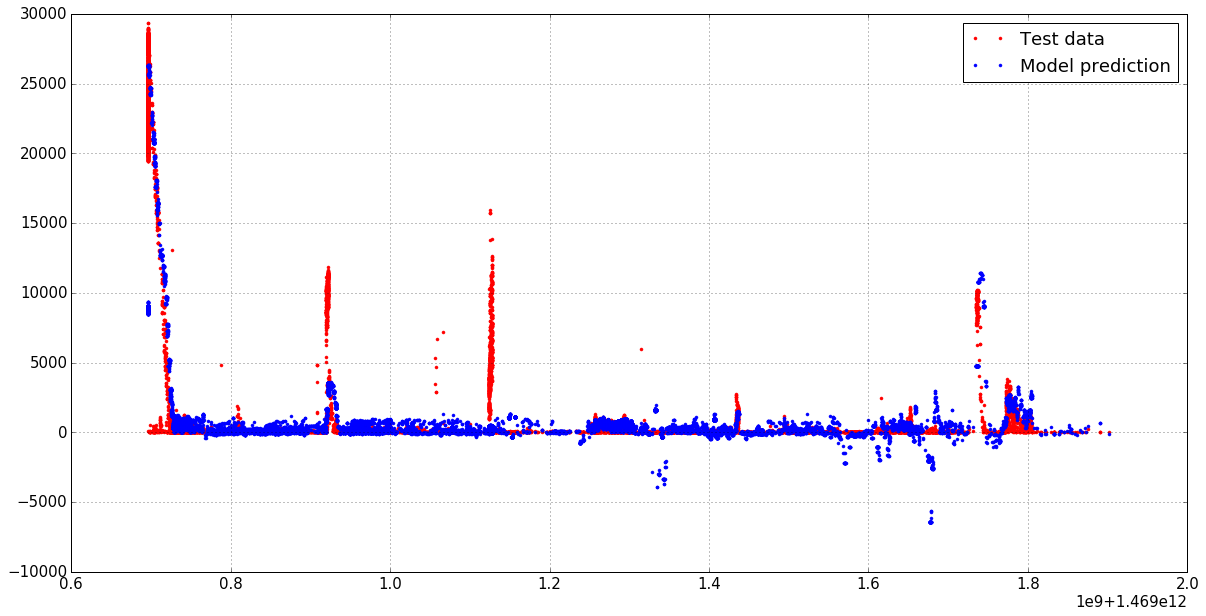

In [259]:
import pandas
from sklearn.linear_model import LinearRegression,BayesianRidge,Lars,Lasso
from sklearn.ensemble import (GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,
                              ExtraTreesRegressor)

sp = int(round(0.8*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = reducedOutput[:sp]
X_test = reducedInput[sp:]
Y_test = reducedOutput[sp:]

model = Lasso()
Y_predict = model.fit(X_train[:,1:],Y_train).predict(X_test[:,1:])

plt.figure(figsize=(20,10))
axd = plt.gca()
plt.plot(X_test[:,0],Y_test,'r.',label='Test data')
plt.plot(X_test[:,0],Y_predict,'b.',label='Model prediction')
#plt.errorbar(X_test[:,0],Y_predict,yerr=np.abs(Y_predict-Y_test),linestyle='None',label='predicted')
plt.grid()
plt.legend()

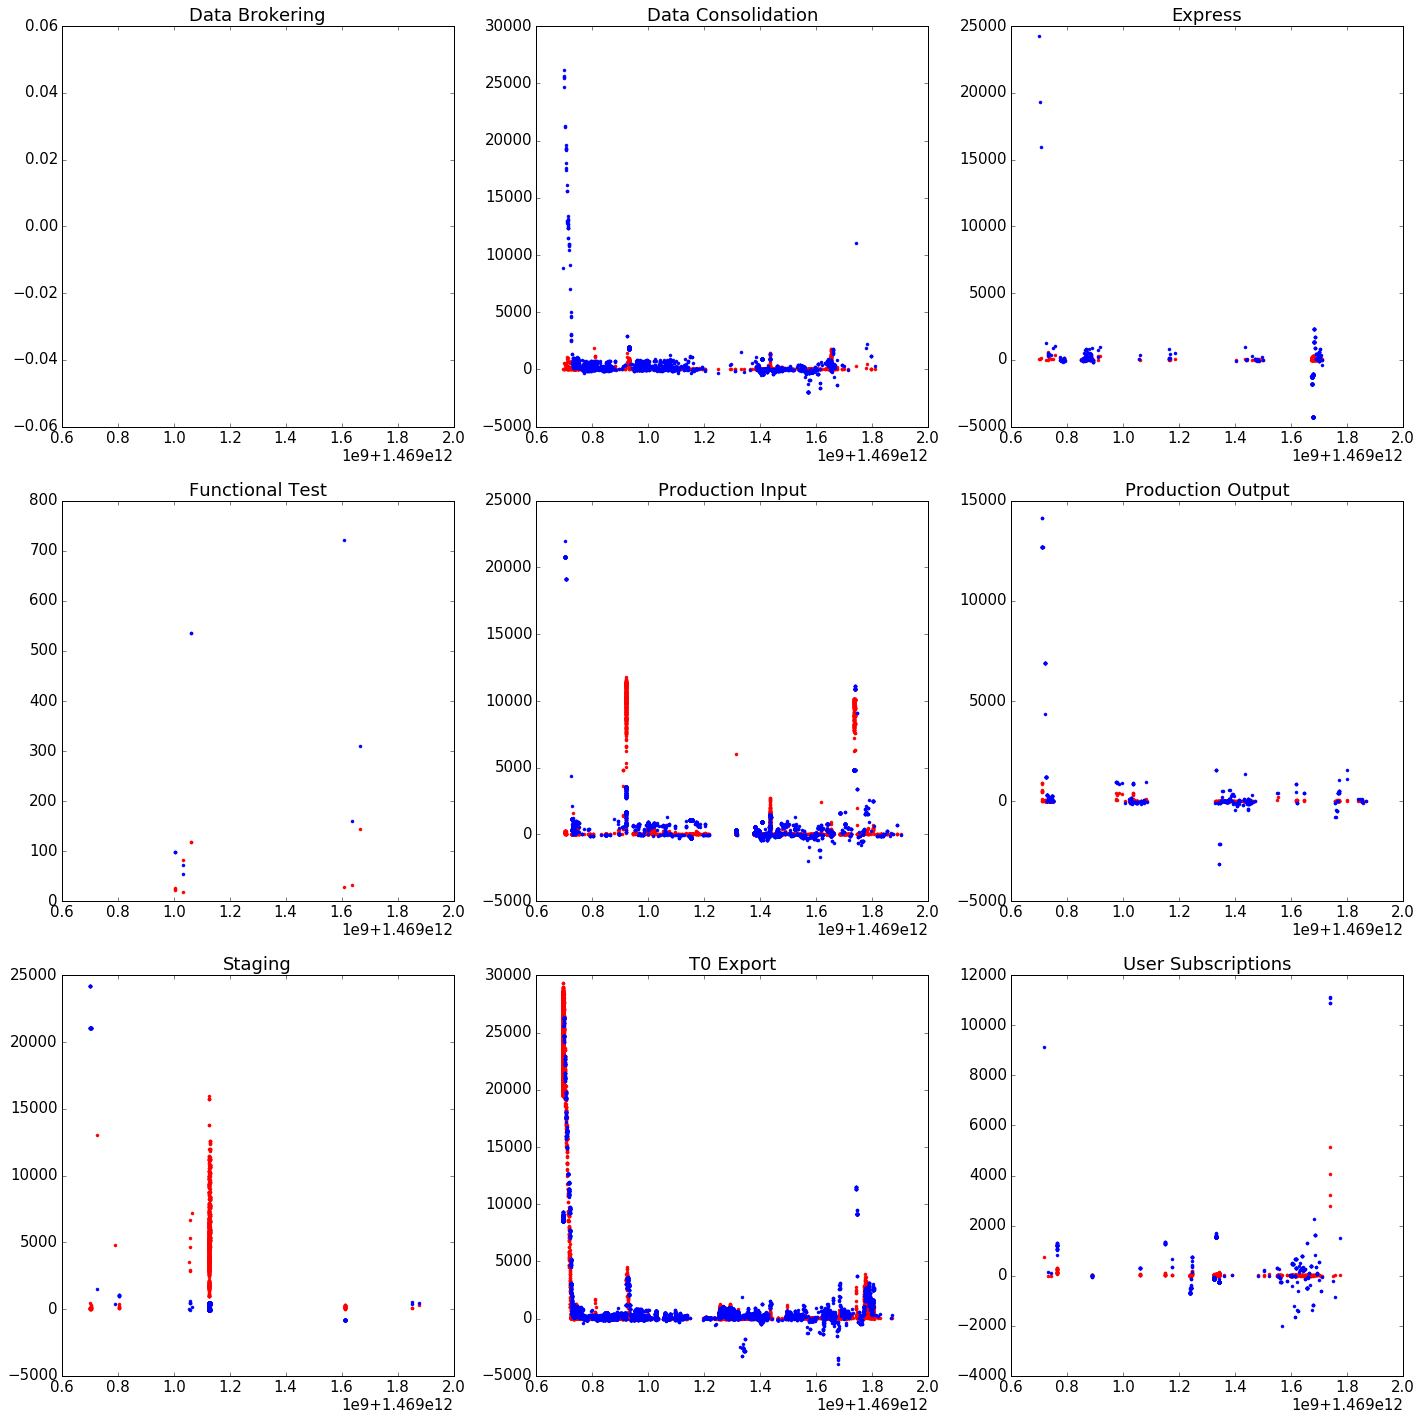

In [255]:
plt.figure(figsize=(20,20))
for u in range(len(uniqueActivities)):
    plt.subplot(3,3,u+1,sharex=axd)
    currentIndex = np.array(activity[sp:])==uniqueActivities[u]
    plt.plot(X_test[currentIndex,0],Y_test[currentIndex],'r.')
    plt.plot(X_test[currentIndex,0],Y_predict[currentIndex],'b.')
    plt.title(uniqueActivities[u])
plt.tight_layout()

Error is reported as the RMSE per TTC category of a particular activity, taken with respect to its corresponding actual result. This is carried out after the data has been converted from continuous to categorical. Since categories are integers that increase as the corresponding time interval of the category increase, the RMSE can still be found and gives a reasonable estimator of the performance.

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


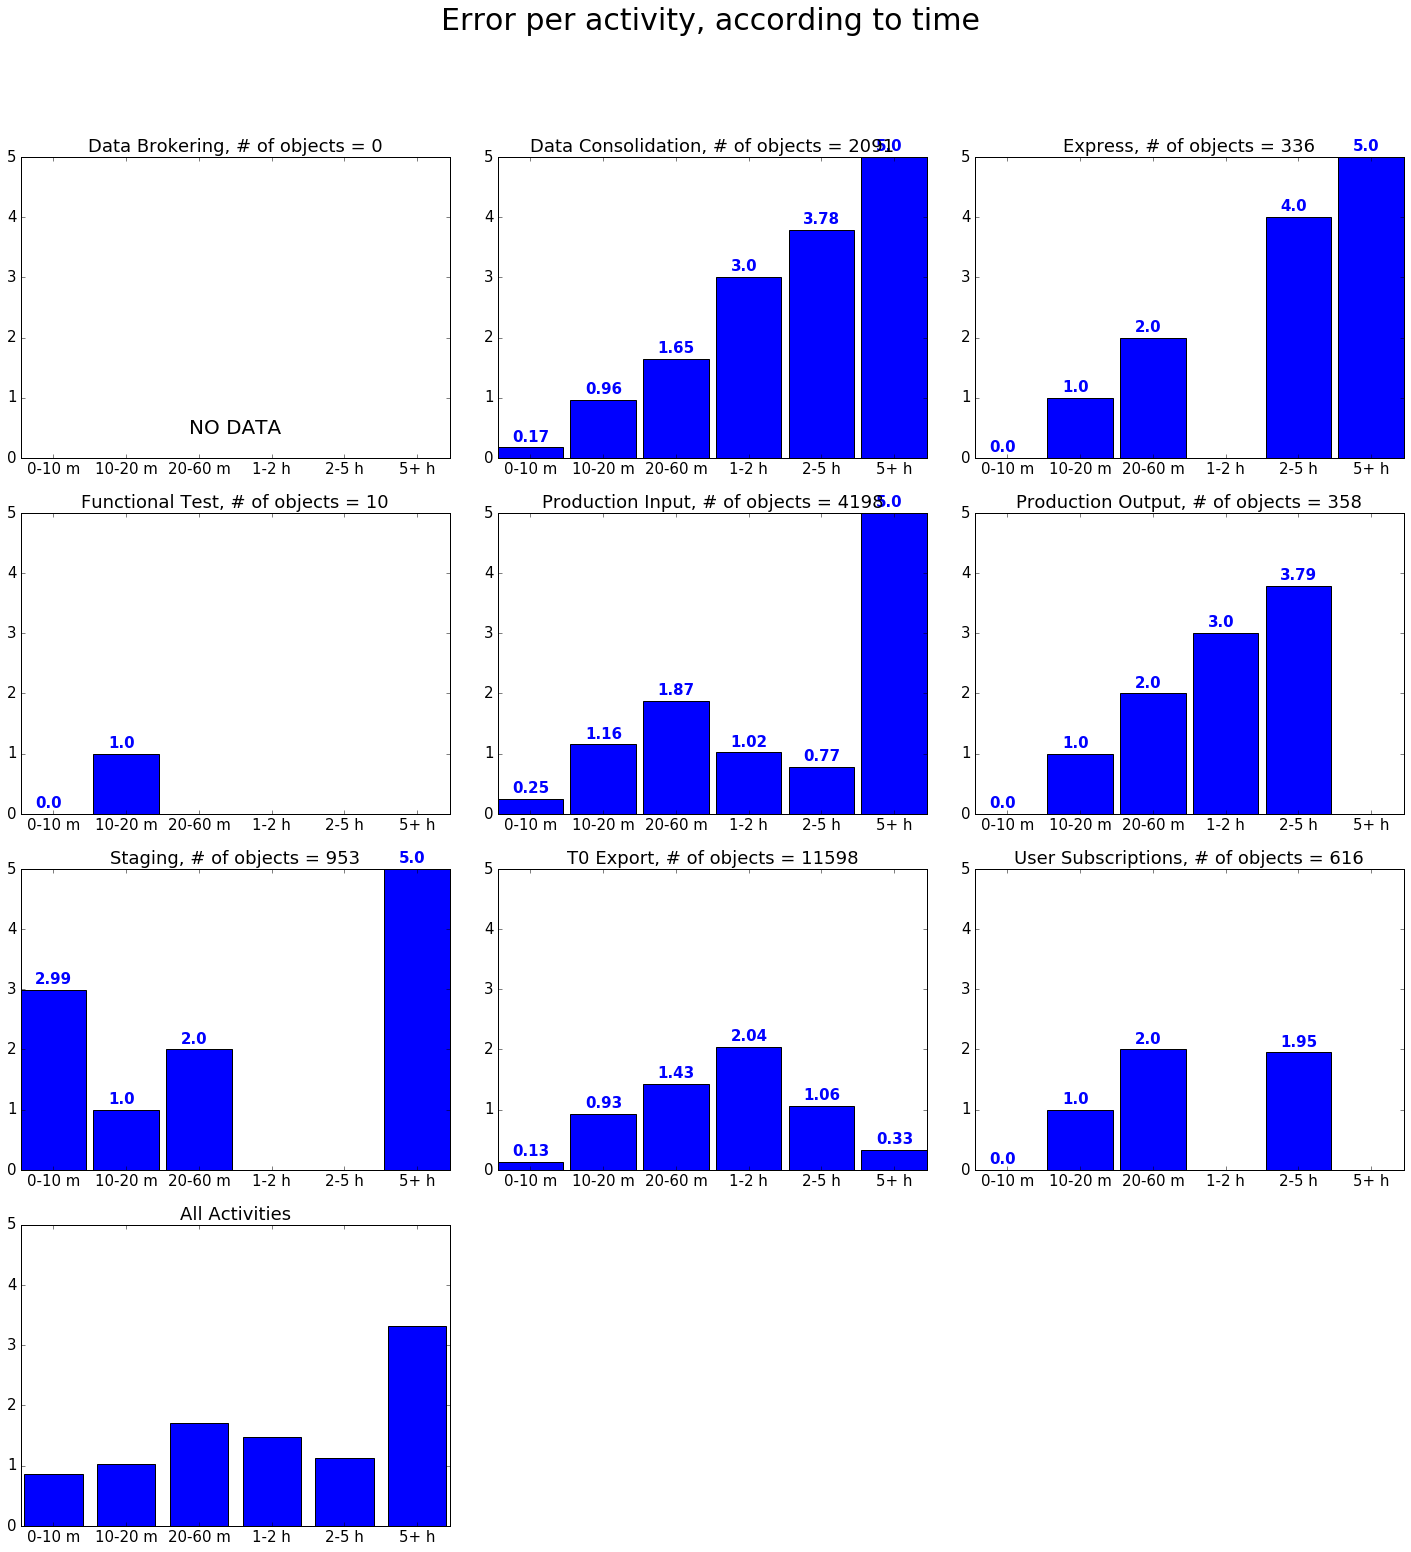

In [256]:
#Get performance statistics, broken down according to activity

rmseTotal = []

#For each activity, get RMSE of the predicted values
yPredictCat = convertSecsToCat(Y_predict)
yTestCat = convertSecsToCat(Y_test)

predictSize = np.zeros(len(uniqueActivities))
for i in range(len(uniqueActivities)):
    currentIndex = np.array(activity[sp:])==uniqueActivities[i]
    currentActivityTest = yTestCat[currentIndex]
    currentActivityPredict = yPredictCat[currentIndex]
    predictSize[i] = len(currentActivityPredict)
    rmse = np.zeros(6)
    
    #For each TTC category, find the predicted files with that TTC index and compared to test data, taking the RMS
    for j in range(6):
        index = (currentActivityPredict==j)
        rmse[j] = np.sqrt(np.mean((currentActivityPredict[index] - currentActivityTest[index])**2.))
    rmseTotal.append(rmse)


#Get total RMSE as well, without separating out the activities 
rmse = np.zeros(6)
for j in range(6):
    index = (yPredictCat==j)
    rmse[j] = np.sqrt(np.mean((yPredictCat[index] - yTestCat[index])**2.))
rmseTotal.append(rmse)

#x-labels for bar plot
timeStr = ['0-10 m','10-20 m','20-60 m', '1-2 h','2-5 h', '5+ h']

plt.figure(figsize=(20,20))
ax1 = plt.subplot(4,3,len(uniqueActivities)+1)
plt.bar(range(6),rmseTotal[len(uniqueActivities)],align='center')
plt.xticks(range(6),timeStr)
plt.title('All Activities')

for i in range(len(uniqueActivities)):
    plt.subplot(4,3,i+1,sharex=ax1,sharey=ax1)
    
    #Place a "NO DATA" label on plot if there is no info for that activity
    if np.sum(np.isnan(rmseTotal[i])) == 6:
        plt.title('%s, # of objects = %i'%(str(uniqueActivities[i]), predictSize[i]))
        plt.annotate('NO DATA', xy=(2.5, 0.5),size=20,ha="center", va="center")
        plt.xticks(range(6),timeStr)
        
    
    else:
        plt.bar(range(6),rmseTotal[i],width=0.9,align='center')
        plt.title('%s, # of objects = %i'%(str(uniqueActivities[i]), predictSize[i]))
        plt.xticks(range(6),timeStr)
        
        ax = plt.gca()
        for u,v in enumerate(rmseTotal[i]):
            if np.logical_not(np.isnan(v)):
                ax.text(u-0.25, v+0.1, str(np.round(v,2)), color='blue', fontweight='bold')

plt.suptitle('Error per activity, according to time',size=30,y=1.08)
plt.tight_layout()
plt.show()


In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,
                              AdaBoostClassifier,ExtraTreesClassifier)

#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dashThroughput1h[:,None],dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]

sp = int(round(0.8*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = convertSecsToCat(reducedOutput[:sp])
X_test = reducedInput[sp:]
Y_test = convertSecsToCat(reducedOutput[sp:])

model1 = ExtraTreesClassifier()

results = model1.fit(X_train[:,1:],Y_train)

Y_predict = results.predict(X_test[:,1:])
Y_proba = results.predict_proba(X_test[:,1:])


/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


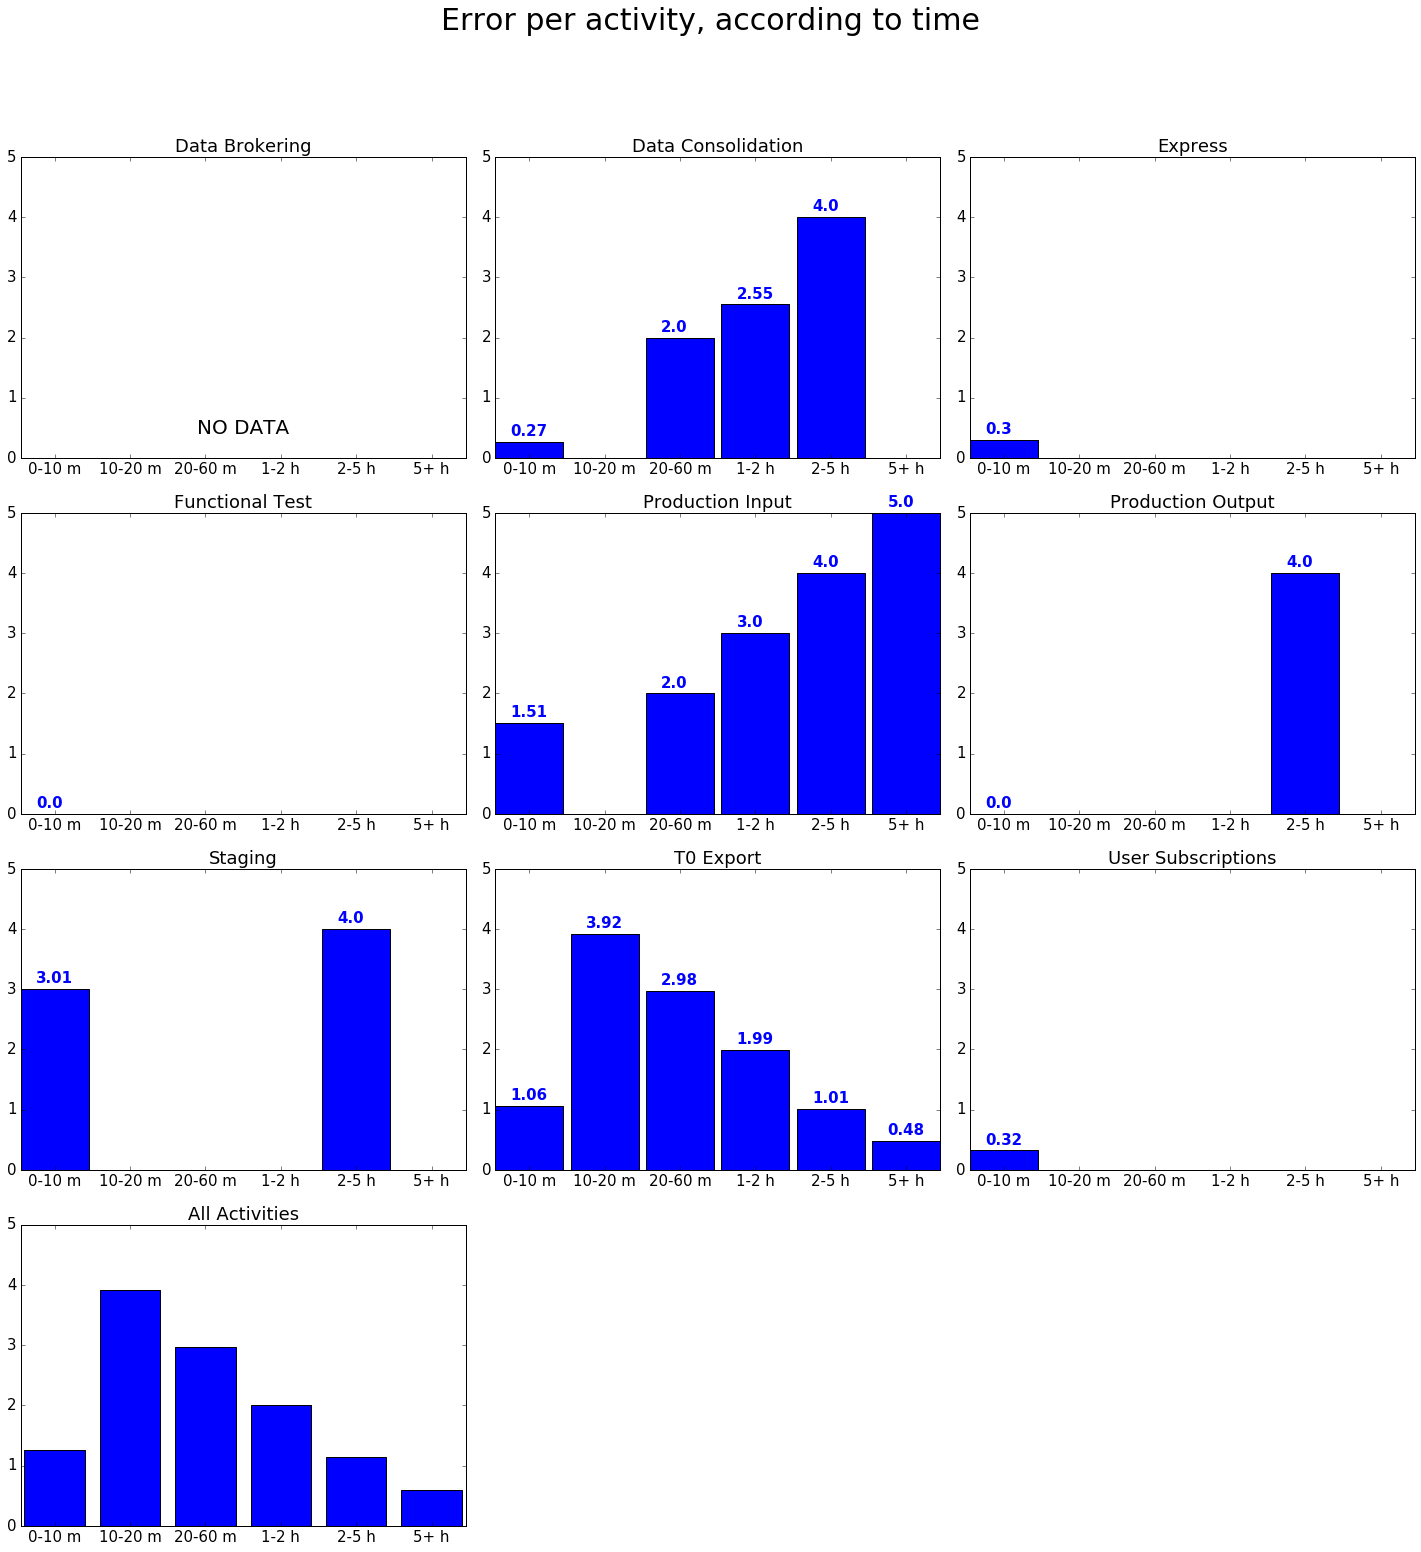

In [171]:
#Get performance statistics, broken down according to activity

rmseTotal = []

#For each activity, get RMSE of the predicted values
yPredictCat = Y_predict
yTestCat = Y_test
for i in range(len(uniqueActivities)):
    currentIndex = np.array(activity[sp:])==uniqueActivities[i]
    currentActivityTest = yTestCat[currentIndex]
    currentActivityPredict = yPredictCat[currentIndex]
    rmse = np.zeros(6)
    for j in range(6):
        index = (currentActivityPredict==j)
        rmse[j] = np.sqrt(np.mean((currentActivityPredict[index] - currentActivityTest[index])**2))
    rmseTotal.append(rmse)


#Get total RMSE as well, without separating out the activities 
rmse = np.zeros(6)
for j in range(6):
    index = (yPredictCat==j)
    rmse[j] = np.sqrt(np.mean((yPredictCat[index] - yTestCat[index])**2))
rmseTotal.append(rmse)

#Bar plot x-labels
timeStr = ['0-10 m','10-20 m','20-60 m', '1-2 h','2-5 h', '5+ h']

plt.figure(figsize=(20,20))
ax1 = plt.subplot(4,3,len(uniqueActivities)+1)
plt.bar(range(6),rmseTotal[len(uniqueActivities)],align='center')
plt.xticks(range(6),timeStr)
plt.title('All Activities')

for i in range(len(uniqueActivities)):
    plt.subplot(4,3,i+1,sharex=ax1,sharey=ax1)
    
    #Place a "NO DATA" label on plot if there is no info for that activity
    if np.sum(np.isnan(rmseTotal[i])) == 6:
        plt.title(str(uniqueActivities[i]))
        plt.annotate('NO DATA', xy=(2.5, 0.5),size=20,ha="center", va="center")
        plt.xticks(range(6),timeStr)
        
    
    else:
        plt.bar(range(6),rmseTotal[i],width=0.9,align='center')
        plt.title(str(uniqueActivities[i]))
        plt.xticks(range(6),timeStr)
        
        ax = plt.gca()
        for u,v in enumerate(rmseTotal[i]):
            if np.logical_not(np.isnan(v)):
                ax.text(u-0.25, v+0.1, str(np.round(v,2)), color='blue', fontweight='bold')

plt.suptitle('Error per activity, according to time',size=30,y=1.08)
plt.tight_layout()
plt.show()